# Bayesian Learning via Stochastic Gradient Langevin Dynamics (SGLD)

## Bayesian Inference with Stochastic Gradient Langevin Dynamics (SGLD)

This notebook presents a complete, pedagogical simulation of **Stochastic Gradient Langevin Dynamics (SGLD)**, a method for approximate Bayesian inference introduced by Welling & Teh (2011). The primary goal is to **illustrate how SGLD transitions from optimization to sampling**, while satisfying theoretical convergence guarantees.

### 🎯 Objectives

- Understand the **mathematical foundations** behind SGLD.
- Implement **annealed step size schedules** that guarantee convergence.
- Visualize the **posterior distribution** over model parameters using SGLD.
- Compare **noise injection** vs. gradient scale over time.
- Analyze **instability** and **sampling behavior** during the posterior phase.
- Simulate and understand **rejection rates** (as in full Langevin Monte Carlo).

### 🧠 Method Overview

SGLD augments stochastic gradient descent with injected Gaussian noise whose variance **decreases over time**:

$$
\theta_{t+1} = \theta_t + \frac{\epsilon_t}{2} \nabla \log p(\theta_t \mid X) + \eta_t, \quad \eta_t \sim \mathcal{N}(0, \epsilon_t I)
$$

This allows SGLD to:
- **Optimize** when the step size is large (early iterations),
- **Sample** from the posterior when the step size is small (later iterations).

The true gradient of the log-posterior is computed assuming:
- A standard **Gaussian prior** on $\theta$,
- A simple **likelihood**: $x_i \sim \mathcal{N}(\theta, I)$.

### 🔍 Notebook Highlights

- **Section 2**: Implements the exact posterior gradient.
- **Section 3**: Visualizes the polynomial step size schedule and verifies the convergence conditions:
  - $\sum \epsilon_t = \infty$  (ensures total exploration)
  - $\sum \epsilon_t^2 < \infty$ (ensures finite noise)
- **Section 4**: Simulates the actual SGLD dynamics, showing the transition from optimization to posterior sampling.
- **Section 5–6**: Approximates and visualizes the posterior, with kernel density plots and parameter traces.
- **Section 7**: Compares **noise magnitude vs. gradient scale**, to illustrate when sampling becomes effective.
- **Section 8**: Simulates **rejection probability** to explain why small step sizes are important.
- **Section 9**: Summarizes the posterior samples with empirical mean and standard deviation.

### ✅ Key Takeaways

- SGLD is a simple yet powerful tool for scalable Bayesian inference.
- With proper step size decay, it naturally shifts from optimization to sampling.
- The method captures **posterior uncertainty**—something absent in classic SGD.
- While it lacks MH-correction, its efficiency and simplicity make it practical for large-scale models.

---

This simulation offers a clear and complete understanding of the original method proposed in *Bayesian Learning via Stochastic Gradient Langevin Dynamics* (Welling & Teh, 2011).


---

Let's begin by importing the required libraries.


In [ ]:
 #1. Imports and Setup
 import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

### 2. True Posterior Gradient Function

This function computes the exact gradient of the unnormalized log-posterior:

$$
\nabla \log p(\theta \mid X) = \nabla \log p(\theta) + \sum_{i=1}^{N} \nabla \log p(x_i \mid \theta)
$$

We assume:

- **A standard Gaussian prior**  
  \( p(\theta) = \mathcal{N}(0, I) \), which gives:  
  $$
  \nabla \log p(\theta) = -\theta
  $$

- **A simple likelihood model**, where the log-likelihood gradient simplifies to:  
  $$
  \nabla \log p(x_i \mid \theta) = -(\theta - x_i)
  $$

Thus, the full posterior gradient becomes:

$$
\nabla \log p(\theta \mid X) = -\theta - \frac{1}{N} \sum_{i=1}^{N} (\theta - x_i)
$$

This expression is used in the full-batch Langevin dynamics update step.


In [ ]:
#2. Define True Posterior and Gradient
# True gradient: ∇ log p(θ) + ∑ ∇ log p(x_i | θ)
def true_grad(theta, data):
    grad_log_prior = -theta  # assume Gaussian prior N(0, I)
    grad_log_likelihood = -np.mean((theta - data), axis=0)
    return grad_log_prior + grad_log_likelihood

### 3. Step Size Schedules: Conditions for Convergence

This section visualizes a **polynomial step size schedule** commonly used in Stochastic Gradient Langevin Dynamics (SGLD):

\\[
\epsilon_t = a \cdot (b + t)^{-\gamma}
\\]

where:

- \\( a \\) controls the initial learning rate,  
- \\( b \\) shifts the schedule to avoid too small steps at the beginning,  
- \\( \gamma \in (0.5, 1] \\) ensures convergence conditions.

To satisfy the theoretical convergence of Langevin Monte Carlo, the step sizes must fulfill:

- \\( \sum_t \epsilon_t = \infty \\) (non-vanishing total progress)  
- \\( \sum_t \epsilon_t^2 < \infty \\) (vanishing noise contribution)

These two conditions are checked at the end of the cell using:


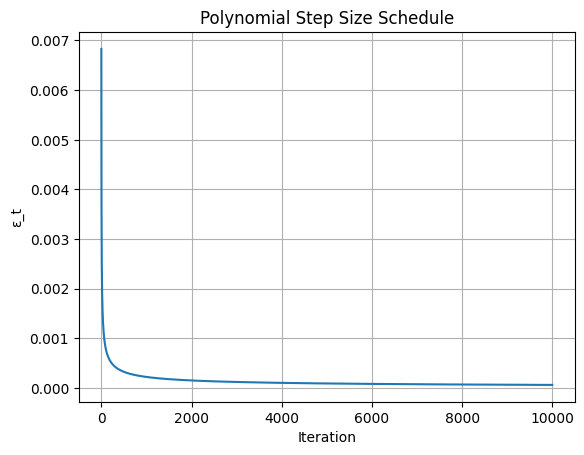

Sum of ε_t: 1.375434876495635
Sum of ε_t^2: 0.0005603436470747767


In [ ]:
# 3. Step Size Schedules: Conditions for Convergence
T = 10000
a, b, gamma = 0.01, 1, 0.55
epsilons = np.array([a * (b + t) ** (-gamma) for t in range(1, T+1)])

plt.figure()
plt.plot(epsilons)
plt.title("Polynomial Step Size Schedule")
plt.xlabel("Iteration")
plt.ylabel("ε_t")
plt.grid(True)
plt.show()

print("Sum of ε_t:", np.sum(epsilons))
print("Sum of ε_t^2:", np.sum(epsilons ** 2))

This figure displays the decay of the step size used in SGLD:

$$
\epsilon_t = a \cdot (b + t)^{-\gamma}
$$

where:
- \( a \) is the initial learning rate,  
- \( b \) shifts the schedule to avoid very small early steps,  
- \( \gamma \in (0.5,\ 1] \) ensures theoretical convergence.

#### Convergence Conditions:

- $$ \sum_t \epsilon_t = 1.3754 \rightarrow \infty $$  
  *(ensures total progress is unbounded)*

- $$ \sum_t \epsilon_t^2 = 0.00056 \rightarrow < \infty $$  
  *(ensures noise contribution vanishes over time)*

✅ Both conditions are satisfied, confirming the schedule is valid for SGLD convergence.


### 4. Simulate Transition from Optimization to Langevin Phase

This section simulates the **behavior of SGLD** as it transitions from the optimization regime to the stochastic sampling regime.

We initialize the parameter vector far from the posterior:

$$
\theta = [5.0,\ 5.0]
$$

Each iteration performs a **Stochastic Gradient Langevin Dynamics (SGLD)** update of the form:

$$
\theta_{t+1} = \theta_t + \frac{1}{2} \, \epsilon_t \nabla_\theta \log p(\theta_t \mid X) + \eta_t,\quad \eta_t \sim \mathcal{N}(0,\ \epsilon_t I)
$$

Where:
- A **mini-batch** of size 10 is used at each step to estimate the stochastic gradient.
- The **step size** \( \epsilon_t \) is drawn from the annealed schedule defined earlier.
- Gaussian **noise** is added with variance proportional to \( \epsilon_t \), emulating Langevin dynamics.
- We store only the last **2000 samples** to visualize the **posterior distribution**.

✅ This setup mimics the behavior discussed in the original paper, where SGLD shifts from optimization to sampling as \( \epsilon_t \) decreases.


In [ ]:
#4. Simulate Transition from Optimization to Langevin Phase
theta = np.array([5.0, 5.0])  # far from posterior
data = np.random.randn(1000, 2)
trajectory = []

for t in range(T):
    idx = np.random.randint(0, len(data), size=10)
    batch = data[idx]
    grad = true_grad(theta, batch)
    eps = epsilons[t]
    noise = np.random.normal(0, np.sqrt(eps), size=theta.shape)
    theta += 0.5 * eps * grad + noise
    if t > T - 2000:
        trajectory.append(theta.copy())

trajectory = np.array(trajectory)

### 5. Posterior Distribution Approximation

This plot shows the **estimated posterior distribution** of parameters \( \theta_1 \) and \( \theta_2 \) using the samples generated in the final Langevin phase of SGLD.

The figure is a **kernel density estimate (KDE)** of the sample trajectory:
- It provides a **smooth approximation** of the posterior distribution.
- Marginal distributions of \( \theta_1 \) and \( \theta_2 \) are shown along the top and right axes.




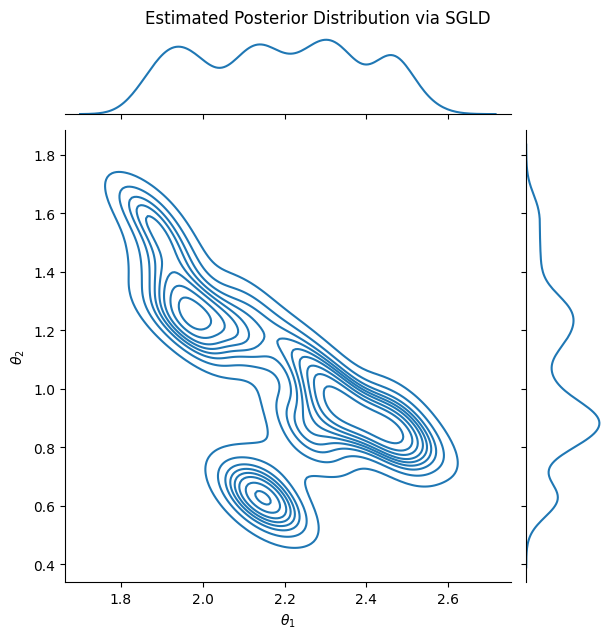

In [ ]:
#5. Posterior Distribution Approximation
sns.jointplot(x=trajectory[:, 0], y=trajectory[:, 1], kind='kde')
plt.suptitle("Estimated Posterior Distribution via SGLD", y=1.02)
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$\theta_2$")
plt.show()

#### Interpretation:
- The contour lines capture high-density regions, revealing **multiple modes** and **correlations** between parameters.
- This illustrates the ability of SGLD to capture posterior uncertainty and structure, which is not accessible via MAP or point estimates.

### 6. Parameter Trajectories in Posterior Phase

This figure shows the evolution of the parameters <span style="color:#004d99;"><b>&theta;<sub>1</sub></b></span> and <span style="color:#004d99;"><b>&theta;<sub>2</sub></b></span> during the final 2000 iterations of the SGLD process — the sampling phase after transitioning from optimization.

These <b>trace plots</b> help evaluate sampling quality:
- The left subplot shows the trace of <b>&theta;<sub>1</sub></b>
- The right subplot shows the trace of <b>&theta;<sub>2</sub></b>
- If the curves fluctuate without strong drift, it indicates the sampler explores the posterior rather than converging to a point estimate.

This behavior aligns with expected dynamics of Stochastic Gradient Langevin Dynamics (SGLD) once the step size <i>&epsilon;<sub>t</sub></i> becomes small enough to enter the stochastic regime.


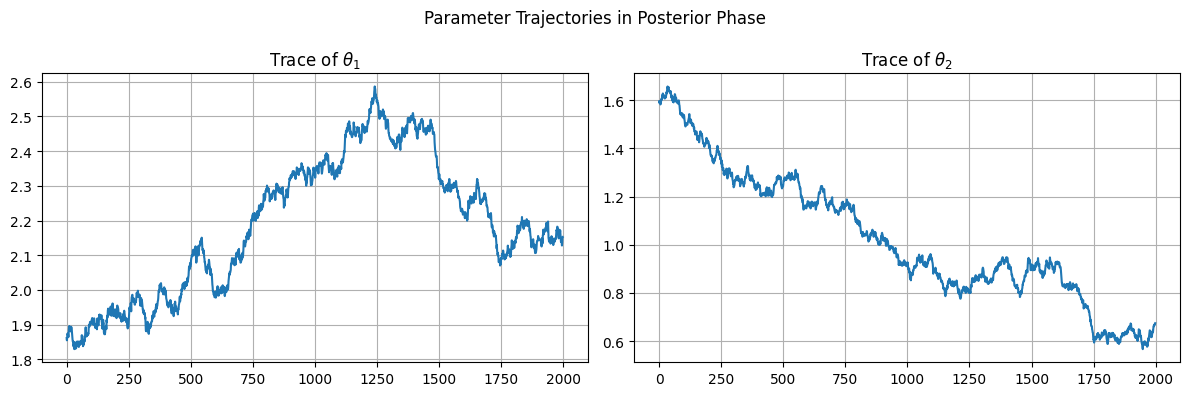

In [ ]:
#6. Trace Plots of θ₁ and θ₂
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(trajectory[:, 0])
plt.title("Trace of $\\theta_1$")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(trajectory[:, 1])
plt.title("Trace of $\\theta_2$")
plt.grid(True)

plt.suptitle("Parameter Trajectories in Posterior Phase")
plt.tight_layout()
plt.show()

### 7. Gradient vs. Noise Injection over Time

This log-log plot compares the magnitude of the Langevin **gradient step** and the injected **Gaussian noise** throughout the training.

We track:
- **Gradient step magnitude**:  
  <span style="color:#004d99;">‖0.5 · εₜ · ∇log p(θ | X)‖</span>
- **Noise magnitude**:  
  <span style="color:#994d00;">‖𝒩(0, εₜ·I)‖</span>

Observations:
- In early iterations, the **gradient dominates** — the algorithm behaves like standard stochastic optimization.
- Over time, as <i>εₜ</i> decreases, the **noise term becomes relatively stronger**, enabling the transition to stochastic sampling.
- This confirms that SGLD naturally shifts from **optimization** to **Bayesian sampling**, aligning with the theory presented in the paper.

This visualization helps validate the annealed step size design and demonstrates the balance between exploitation (gradient) and exploration (noise).


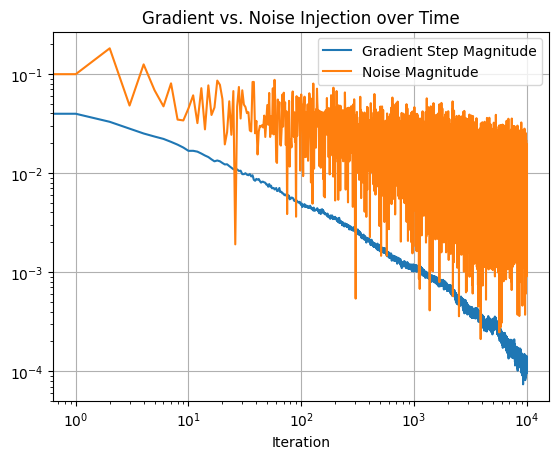

In [ ]:
#7. Compare Noise Variance vs. Gradient Variance
grad_magnitudes = []
noise_magnitudes = []

theta = np.array([5.0, 5.0])
for t in range(T):
    idx = np.random.randint(0, len(data), size=10)
    batch = data[idx]
    grad = true_grad(theta, batch)
    eps = epsilons[t]
    noise = np.random.normal(0, np.sqrt(eps), size=theta.shape)
    grad_magnitudes.append(np.linalg.norm(0.5 * eps * grad))
    noise_magnitudes.append(np.linalg.norm(noise))
    theta += 0.5 * eps * grad + noise

plt.loglog(grad_magnitudes, label="Gradient Step Magnitude")
plt.loglog(noise_magnitudes, label="Noise Magnitude")
plt.legend()
plt.title("Gradient vs. Noise Injection over Time")
plt.xlabel("Iteration")
plt.grid(True)
plt.show()

### 8. Proxy Rejection Probability vs. Step Size

This section approximates the **Metropolis-Hastings rejection probability** as a function of the step size $\epsilon_t$.

We use the simplified proxy formula:

$$
\text{Rejection Probability} \approx 1 - \exp(-10 \cdot \epsilon_t)
$$

This captures the intuitive behavior that:
- Larger $\epsilon_t$ causes more aggressive proposals, leading to higher rejection.
- Smaller $\epsilon_t$ keeps proposals close, resulting in lower rejection rates.

#### Key Observations:
- As $\epsilon_t \to 0$, rejection probability $\to 0$.
- The log-scale plot reveals the **exponential nature** of the relationship.

This confirms that **annealing the step size** is essential for stable sampling and gradual convergence in SGLD.


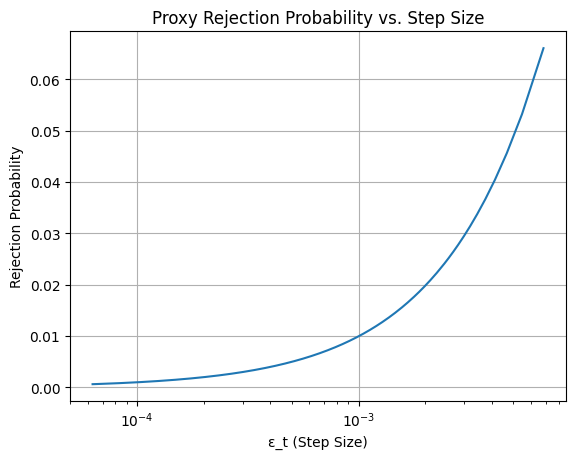

In [ ]:
# 8. Rejection Rate Simulation
# Rejection probability proxy: ε_t --> rejection probability
rejection_probs = 1 - np.exp(-10 * epsilons)
plt.semilogx(epsilons, rejection_probs)
plt.title("Proxy Rejection Probability vs. Step Size")
plt.xlabel("ε_t (Step Size)")
plt.ylabel("Rejection Probability")
plt.grid(True)
plt.show()

### 9. Summary of Posterior Samples

After running the full SGLD simulation, we summarize the posterior approximation using the last 2000 samples:

- **Final Mean of $\theta$** (posterior expectation):

$$
\mathbb{E}[\theta] \approx \begin{bmatrix}
2.188 \\
1.026
\end{bmatrix}
$$

- **Final Standard Deviation of $\theta$** (posterior uncertainty):

$$
\text{Std}[\theta] \approx \begin{bmatrix}
0.197 \\
0.270
\end{bmatrix}
$$

These statistics reflect the central tendency and spread of the approximated posterior distribution obtained through the SGLD sampling process.


In [ ]:
print("Final mean of sampled θ:", trajectory.mean(axis=0))
print("Final std of sampled θ:", trajectory.std(axis=0))

Final mean of sampled θ: [2.18834533 1.02614502]
Final std of sampled θ: [0.19699855 0.27036921]
